# Chapter 3: Text Embeddings

## 3.1 Embeddings

Embeddings are procedures that turn input data into vectors.  Recall from chapter 1 that there are 2 kinds:
* Representational embeddings are designed by hang and thus human-interpretable.
* Operational embeddings are learned from data

In [28]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import codecs
import re

### 3.1.1 Embed by Hand: Representational Embeddings
**one-hot embeddings**
Every element of this vector embedding is zero, except at a single meaningful index.
<img src="images/oneHot.png/">
Given the embedding above:
The word _cat_ is represented by the vector $ [0, 1, 0, 0, 0, 0 ]$.
The word _sat_ is represented by the vector $ [0, 0, 1, 0,0, 0, ]$

In [20]:
def one_hot(lexicon, word):
    '''


    :param lexicon: A sentence string
    :param word: a string
    :return: np.array one-hot vector representing the word from the given lexicon
    '''
    lexicon = np.array(lexicon.split(' ')) # split sentence into words
    return np.multiply(lexicon == word, 1) # multiply turns True/False into integers 1, 0

lex = 'want to go swim at the beach'

one_hot(lex, 'beach' )

array([0, 0, 0, 0, 0, 0, 1])

Ideally, words that are related to each other will generally lie close to each other in vector space, but note below that there spatial distance does not make sense from a linguistic perspective since different one-hot vectors only differ by just one bit.
As such one-hot embeddings are used when distance-based similarity does not come into play.

In [21]:
a = one_hot(lex, 'beach')
b = one_hot(lex, 'swim')
c = one_hot(lex, 'want')
print(f'distance between \"beach\" and \"swim\": {np.linalg.norm(a - b)}')
print(f'distance between \"beach\" and \"want\": {np.linalg.norm(a - c)}')


distance between "beach" and "swim": 1.4142135623730951
distance between "beach" and "want": 1.4142135623730951


### 3.1.1 Learning to Embed: Procedural embeddings
Keras Embeddings layers deploy a matrix of weights that are optimized (like a mini single layer network) using a loss function.
The implicit, default loss function is one that maximizes the distinctiveness of vector representations.

The embedding below generates, for every array of 10 integers (a row in the input matrix), a 10x8 matrix consisting of 8-dimensional values, one for every integer in the integer array.


In [22]:

model = Sequential() # create the model container
model.add(Embedding(input_dim=100, output_dim=8, input_length=10))   # add an embedding for 100 integers, arranged in blocks of 10
input_array = np.random.randint(100, size=(10, 10)) # a random input
model.compile('rmsprop', 'mse') # “compile the model, setting the loss function to 'mean squared error', and using the rmsprop optimizer. ”
output_array = model.predict(input_array) # generate embeddings
print(f'input dim: {input_array.shape}')
print(f'output dim: {output_array.shape}')

input dim: (10, 10)
output dim: (10, 10, 8)


Applied to text, we can represent a set of documents as a vector of integers and create a standard embedding of these documents in a similar way

In [23]:

docs=["Chuck Berry rolled over everyone who came before him ? and turned up everyone who came after. We'll miss you",
      "Help protect the progress we've made in helping millions of Americans get covered.",
      "Let's leave our children and grandchildren a planet that's healthier than the one we have today.",
      "The American people are waiting for Senate leaders to do their jobs.",
      "We must take bold steps now ? climate change is already impacting millions of people.",
      "Don't forget to watch Larry King tonight",
      "Ivanka is now on Twitter - You can follow her",
      "Last night Melania and I attended the Skating with the Stars Gala at Wollman Rink in Central Park",
      "People who have the ability to work should. But with the government happy to send checks",
      "I will be signing copies of my new book"]

docs=[d.lower() for d in docs] # make everything lower case

count_vect = CountVectorizer().fit(docs) # maps every word to a unique arbitrary integer from the vocabulary
tokenizer = count_vect.build_tokenizer() # initialize a tokenizer

print(count_vect.vocabulary_)



input_array=[]
for doc in docs:
    x=[]
    for token in tokenizer(doc): #tokenizer(doc) just splits the string on white spaces to get a list of word strings
        x.append(count_vect.vocabulary_.get(token)) # get the integer from the vocabulary assigned to each word in the doc
    input_array.append(x)


max_len=max([len(d) for d in input_array]) # max length of document
input_array=pad_sequences(input_array, maxlen=max_len, padding='post') # pad with zeros so all vectors are the same length


{'chuck': 21, 'berry': 11, 'rolled': 74, 'over': 67, 'everyone': 27, 'who': 97, 'came': 15, 'before': 10, 'him': 41, 'and': 5, 'turned': 90, 'up': 92, 'after': 1, 'we': 96, 'll': 53, 'miss': 57, 'you': 102, 'help': 38, 'protect': 72, 'the': 85, 'progress': 71, 've': 93, 'made': 54, 'in': 43, 'helping': 39, 'millions': 56, 'of': 63, 'americans': 4, 'get': 32, 'covered': 24, 'let': 52, 'leave': 51, 'our': 66, 'children': 20, 'grandchildren': 34, 'planet': 70, 'that': 84, 'healthier': 37, 'than': 83, 'one': 65, 'have': 36, 'today': 88, 'american': 3, 'people': 69, 'are': 6, 'waiting': 94, 'for': 29, 'senate': 75, 'leaders': 50, 'to': 87, 'do': 25, 'their': 86, 'jobs': 46, 'must': 58, 'take': 82, 'bold': 12, 'steps': 81, 'now': 62, 'climate': 22, 'change': 18, 'is': 44, 'already': 2, 'impacting': 42, 'don': 26, 'forget': 30, 'watch': 95, 'larry': 48, 'king': 47, 'tonight': 89, 'ivanka': 45, 'on': 64, 'twitter': 91, 'can': 16, 'follow': 28, 'her': 40, 'last': 49, 'night': 61, 'melania': 55,

We can visualize the vector embeddings with the well-known visualization algorithm T-SNE (MaatenHinton2008). This algorithm maps high-dimensional vectors to lower-dimensional planes.

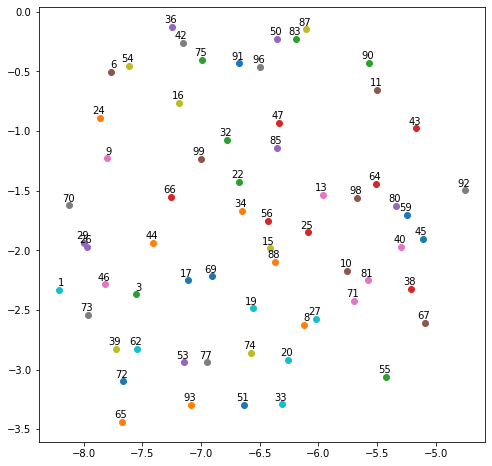

In [25]:
def tsne_plot(model,max_words=100):
    labels = []
    tokens = []

    n=0
    for word in model:
        if n<max_words:
            tokens.append(model[word])
            labels.append(word)
            n+=1


    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(8, 8))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

model = Sequential()
model.add(Embedding(100, 8, input_length=10))
input_array = np.random.randint(100, size=(10, 10))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)

M={}
for i in range(len(input_array)):
    for j in range(len(input_array[i])):
        M[input_array[i][j]]=output_array[i][j]

tsne_plot(M)

 - so a lexicon is represented by a vocabulary that maps words to integers.
 - a single word is represented by an _integer_.
 - each _integer_ is then represented by the output of `model.predict()`, which gives an 8-dimensional array
So each word is represented by this 8-dim vector in model output space.

Note that spatial distance in the plot above does not reflect any semantic differences because our choice of optimizer `(rmsprop)` for the Embed layer didn't account for this.

**Training a word embedding**
with training of the Embedding layer, words should be vectorized such that _they contribute maximally to discerning documents with positive sentiment from those with negative sentiment._
In other words, the word embeddings that are learned are optimized in the context of a specific task.

**Optimization of a Keras embessing.**
A vector of integers (representing a set of documents) where each integer corresponds to a word string. Similar to the case above with random integers, but now we can add labels to denote positive and negative sentiment.
We now train a word embedding constrained by a loss function that aims for _maximum separation of the documents_.

In [ ]:

def save_embedding(outputFile, weights, vocabulary):
    rev = {v:k for k, v in vocabulary.iteritems()}
    with codecs.open(outputFile, "w") as f:
        f.write(str(len(vocabulary)) + " " + str(weights.shape[1]) + "\n")
        for index in sorted(rev.iterkeys()):
            word=rev[index]
            f.write(word + " ")
            for i in range(len(weights[index])):
                f.write(str(weights[index][i]) + " ")
            f.write("\n")


def getLines(f):
    lines = [line.rstrip() for line in open(f)]
    return lines



def create_vocabulary(vocabulary, sentences):
    vocabulary["<unk>"]=0
    for sentence in sentences:
        for word in sentence.strip().split():
            word=re.sub("[.,:;'\"!?()]+","",word.lower())
            if word not in vocabulary:
                vocabulary[word]=len(vocabulary)


def process_training_data(textFile,max_len):
    data=[]
    sentences = getLines(textFile)
    vocab = dict()
    labels=[]
    create_vocabulary(vocab, sentences)
    for s in sentences:
        words=[]
        m=re.match("^([^\t]+)\t(.+)$",s.rstrip())
        if m:
            sentence=m.group(1)
            labels.append(int(m.group(2)))
        for w in sentence.split(" "):
            w=re.sub("[.,:;'\"!?()]+","",w.lower())
            if w!='':
                words.append(vocab[w])
        data.append(words)
    data = pad_sequences(data, maxlen=max_len, padding='post')

    return data,labels, vocab


def process_test_data(textFile,vocab,max_len):
    data=[]
    sentences = getLines(textFile)
    labels=[]
    create_vocabulary(vocab, sentences)
    for s in sentences:
        words=[]
        m=re.match("^([^\t]+)\t(.+)$",s.rstrip())
        if m:
            sentence=m.group(1)
            labels.append(int(m.group(2)))
        for w in sentence.split(" "):
            w=re.sub("[.,:;'\"!?()]+","",w.lower())
            if w!='':
                if w in vocab:
                    words.append(vocab[w])
                else:
                    words.append(vocab["<unk>"])
        data.append(words)
    data = pad_sequences(data, maxlen=max_len, padding='post')
    return data,labels


max_len=100
data,labels,vocab=process_training_data(sys.argv[1],max_len)  # TODO find right data file path
test_data,test_labels=process_test_data(sys.argv[2],vocab,max_len) # TODO find right data file path

model = Sequential()
embedding=Embedding(len(vocab), 100, input_length=max_len)
model.add(embedding)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])
model.fit(data,labels,epochs=100, verbose=1)

loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(accuracy)

save_embedding("embedding_labeled.txt", embedding.get_weights()[0], vocab)



## 3.2 From Words to Vectors: word2vec

## 3.3 From Documents to Vector: doc2vec

## 3.4 Summary